In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

%matplotlib inline

import os
import re
import json
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from map4 import MAP4Calculator

## Read dataset

In [2]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (mhci['length'] == 9) &
            (~mhci['affinity_binding'].isin(dirty_values))]

## Correlation between PSSM and exp. values

In [4]:
data = []
AA = []

with open('../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-9.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:-1]:
        sline = line.strip().split('\t')
        AA.append(sline[0])
        data.append([float(v) for v in sline[1:]])

columns = list(range(1, 10))
pssm = pd.DataFrame(data=data, columns=columns, index=AA)

In [5]:
pssm_scores = []

for peptide in mhci.itertuples():
    score = 0
    
    for i, aa in enumerate(peptide.sequence):
        score += pssm.loc[aa][i + 1]
    
    pssm_scores.append(score)
    
pssm_scores = np.array(pssm_scores)

In [6]:
# Fit PSSM score to exp. values
reg = LinearRegression()
reg.fit(pssm_scores[:,None], mhci['energy'])
print('R2: %.3f' % reg.score(pssm_scores[:,None], mhci['energy']))
print('RMSD : %.3f kcal/mol' % rmsd(reg.predict(pssm_scores[:,None]), mhci['energy']))

R2: 0.644
RMSD : 1.189 kcal/mol


## Bayesian optimization

In [7]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [8]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [9]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

In [36]:
def predict_peptide_affinity_binding(sequences, pssm, reg, cutoff=-5.0):
    scores = []
    
    for sequence in sequences:
        score = 0
        
        for i, aa in enumerate(sequence):
            if pssm.loc[aa][i + 1] >= 0.1:
                score += 999
            else:
                score += pssm.loc[aa][i + 1]
        
        scores.append(score)
    
    pred_scores = reg.predict(np.array(scores)[:,None])
    pred_scores[pred_scores > cutoff] = 0.
    
    return pred_scores


def generate_random_peptides(n_peptides, peptide_length, pssm, reg, energy_bounds, energy_cutoff):
    random_peptides = []
    random_peptide_scores = []

    while True:
        p = ''.join(np.random.choice(pssm.index, peptide_length))
        s = predict_peptide_affinity_binding([p], pssm, reg, cutoff=energy_cutoff)[0]

        if energy_bounds[0] <= s <= energy_bounds[1]:
            random_peptides.append(p)
            random_peptide_scores.append(s)
            print(len(random_peptides))

        if len(random_peptides) == n_peptides:
            break

    random_peptides = np.array(random_peptides)
    random_peptide_scores = np.array(random_peptide_scores)
    
    return random_peptides, random_peptide_scores

In [11]:
def map4_fingerprint(molecule_strings, input_type='fasta', dimensions=4096, radius=2, is_counted=False, is_folded=True):
    f = {'fasta': Chem.rdmolfiles.MolFromFASTA,
         'smiles': Chem.rdmolfiles.MolFromSmiles,
         'helm': Chem.rdmolfiles.MolFromHELM}
    
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([f[input_type](s) for s in molecule_strings])
    return torch.from_numpy(np.array(fps)).float()

In [12]:
class AcqScoring:
    def __init__(self, model, acq_fun, y_exp, sequence_type='fasta'):
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        self._sequence_type = sequence_type
        
    def evaluate(self, sequences):
        fps = map4_fingerprint(sequences, self._sequence_type)
        return self._acq_fun(self._model, self._y_exp, fps)

### Generate random peptides

In [37]:
n_peptides = 150
peptide_length = 9
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

# Generate random peptides
random_peptides, random_peptide_scores = generate_random_peptides(n_peptides, peptide_length, pssm, reg, energy_bounds, energy_cutoff)

print(random_peptides)
print(random_peptide_scores)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
['SFYNDQICM' 'GVVGVFHSW' 'STFAMSTAW' 'VTAFIQYPF' 'WAVAAIAMT' 'CISYGAFPS'
 'SLLHSPTMW' 'IWDHVMLAI' 'CVNPDWCYI' 'FQLAMAVHF' 'WQAGSIPTC' 'RWAGYQLYS'
 'RQSDLTLPS' 'VFMTCMCST' 'IWNECYHAC' 'WISAYAFHS' 'WVDPCSWTS' 'KQLGICMPF'
 'GVYHINTMW' 'LAFMCYIYT' 'CTLFGCMWC' 'GWLMITPCS' 'CIIHGPMHW' 'CQLCVWMAW'
 'CVDPIFMTW' 'AVMMAQMWW' 'RIVMDYTEA' 'VWAHIMHMI' 'VWIPACVYC' 'AAFDVCVTW'
 'WTNECVLMC' 'AIDTIAMCC' 'CTVCVAMYM' 'RIAPWQATF' 'GVITSFCEC' 'LAMEVVMTS'
 'MTYDHWALW' 'WQNTDTCMS' 'WFFSCPTSF' 'LQISAYLAT' 'IVDACFCWS' 'GQNACWHH

### Candidate peptides sampling with PBIL

In [40]:
class PBIL(object):
    def __init__(self, scorer, peptide_length=9, population_size=96, n_best=48,
                 learning_rate=0.5, mut_prob=0.0, mut_shift=0.00, greater_is_better=True, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        
        # Scoring object
        self._scorer = scorer
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._greater_is_better = greater_is_better
        self._best_score = np.inf * (-1) ** (self._greater_is_better)

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        return self._scorer.evaluate([''.join(individual)])[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])
        
        if self._greater_is_better:
            sorted_peptide_indices = np.argsort(np.ravel(scores))[::-1]
        else:
            sorted_peptide_indices = np.argsort(np.ravel(scores))
        
        best_peptide_indices = sorted_peptide_indices[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
            
            for amino_acid in amino_acids:
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])
            
            
def find_next_candidates(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96

    #Initialize the PBIL EDA
    pbil = PBIL(scorer, peptide_length=NLEN, population_size=NIND, n_best=NBEST,
                greater_is_better=greater_is_better)

    scaling_factor = (-1) ** (not greater_is_better)
    creator.create("Fitness", base.Fitness, weights=(scaling_factor,))
    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", pbil.evaluate)
    toolbox.register("generate", pbil.generate, creator.Individual)
    toolbox.register("update", pbil.update)

    # Statistics computation
    hof = tools.HallOfFame(NCAN)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)
    
    candidates = [''.join(s) for s in hof.items]
    candidates_acq = np.array([k.values[0] for k in hof.keys])

    return candidates, candidates_acq

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0313823	0.0261305	-0.163186	-0.000808947
1  	250   	-0.0498289	0.0339047	-0.238199	-0.00139615 
2  	250   	-0.0630215	0.0393925	-0.287852	-0.00925545 
3  	250   	-0.0740724	0.0368174	-0.222303	-0.0109635  
4  	250   	-0.0891334	0.0386524	-0.233801	-0.0155573  
5  	250   	-0.0985692	0.0411551	-0.253831	-0.0181056  
6  	250   	-0.10855  	0.0422409	-0.306566	-0.0169138  
7  	250   	-0.115507 	0.0457778	-0.29924 	-0.0366641  
8  	250   	-0.125027 	0.0427406	-0.269888	-0.0373046  
9  	250   	-0.131273 	0.0474888	-0.291952	-0.0364425  

N pep:  246
Best peptide: -11.655
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 028
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 155
N pep under -5 kcal/mol: 156
Non binding pep        : 090


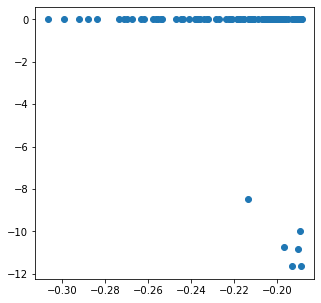




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00443175	0.00583442	-0.0304007	-3.38128e-07
1  	250   	-0.008878  	0.0130776 	-0.136238 	-6.68559e-07
2  	250   	-0.0113885 	0.010776  	-0.0587251	-3.53721e-05
3  	250   	-0.0168419 	0.0138105 	-0.107747 	-4.35842e-05
4  	250   	-0.0190806 	0.0150782 	-0.113002 	-0.000319454
5  	250   	-0.0204401 	0.0177129 	-0.108784 	-0.000160354
6  	250   	-0.0241272 	0.0207217 	-0.175404 	-0.00135132 
7  	250   	-0.0262178 	0.0196083 	-0.101948 	-0.00237558 
8  	250   	-0.0290787 	0.0219944 	-0.174485 	-0.00156377 
9  	250   	-0.0317332 	0.0201306 	-0.127242 	-0.00497781 

N pep:  342
Best peptide: -11.655
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 165
N pep under -5 kcal/mol: 166
Non binding pep        : 176


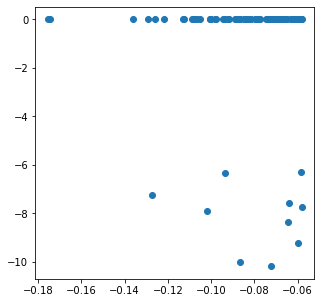




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max         
0  	250   	-0.0080574	0.0135791	-0.0966405	-1.73955e-06
1  	250   	-0.0156188	0.0209419	-0.118194 	-2.35468e-05
2  	250   	-0.0232291	0.0247805	-0.120081 	-0.000169933
3  	250   	-0.0300356	0.0335957	-0.210193 	-8.37672e-05
4  	250   	-0.0385903	0.0347745	-0.201481 	-0.000239028
5  	250   	-0.0366935	0.0327811	-0.164469 	-7.27566e-05
6  	250   	-0.0429678	0.037332 	-0.232246 	-0.000624458
7  	250   	-0.0461895	0.0410238	-0.26004  	-0.00103782 
8  	250   	-0.0537068	0.048252 	-0.4088   	-0.00109428 
9  	250   	-0.0556673	0.0469879	-0.221634 	-0.0011751  

N pep:  438
Best peptide: -11.655
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 010
N pep under -9 kcal/mol: 022
N pep under -8 kcal/mol: 052
N pep under -7 kcal/mol: 160
N pep under -6 kcal/mol: 193
N pep under -5 kcal/mol: 194
Non binding pep        : 244


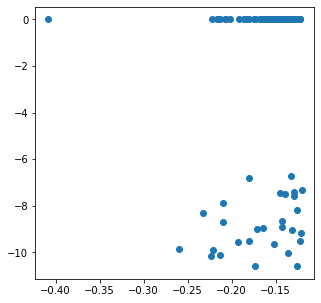




Run: 2
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0280831	0.0229052	-0.126344	-7.76629e-05
1  	250   	-0.0434224	0.0294772	-0.160229	-0.002152   
2  	250   	-0.057774 	0.0357989	-0.223304	-0.00406509 
3  	250   	-0.0727302	0.0422085	-0.264233	-0.00515573 
4  	250   	-0.0840947	0.0396167	-0.240272	-0.0128555  
5  	250   	-0.0968349	0.0427477	-0.261387	-0.0140518  
6  	250   	-0.104679 	0.0420823	-0.226476	-0.026977   
7  	250   	-0.109311 	0.0429498	-0.336124	-0.0270531  
8  	250   	-0.119696 	0.0411319	-0.239785	-0.0394143  
9  	250   	-0.130228 	0.0453023	-0.297044	-0.034052   

N pep:  246
Best peptide: -10.783
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 152
Non binding pep        : 094


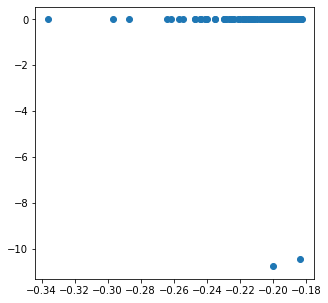




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max         
0  	250   	-0.00570437	0.0111853	-0.094689	-6.73486e-07
1  	250   	-0.0122734 	0.015205 	-0.107937	-1.68782e-05
2  	250   	-0.0204648 	0.0185662	-0.105297	-6.21163e-05
3  	250   	-0.0319907 	0.0229683	-0.116534	-0.000737263
4  	250   	-0.0394815 	0.0321583	-0.220486	-0.00131452 
5  	250   	-0.0457591 	0.0319613	-0.212938	-0.00388617 
6  	250   	-0.0463183 	0.0297014	-0.160453	-0.00068315 
7  	250   	-0.0525583 	0.033435 	-0.262946	-0.00681997 
8  	250   	-0.056291  	0.0422539	-0.366439	-0.00820541 
9  	250   	-0.0597005 	0.0338858	-0.190171	-0.00892929 

N pep:  342
Best peptide: -10.783
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 156
N pep under -5 kcal/mol: 158
Non binding pep        : 184


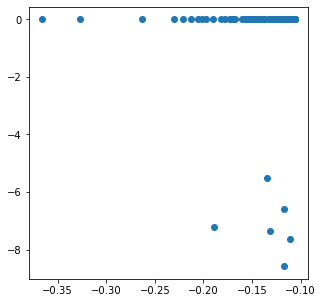




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max         
0  	250   	-0.00715083	0.0143402	-0.108749	-1.20902e-05
1  	250   	-0.0130069 	0.0169252	-0.105296	-1.0641e-05 
2  	250   	-0.020394  	0.0240624	-0.128245	-3.55652e-05
3  	250   	-0.0296689 	0.0388978	-0.282032	-3.17625e-05
4  	250   	-0.0353247 	0.0420863	-0.250058	-0.000433236
5  	250   	-0.0502016 	0.0578099	-0.417184	-7.45854e-05
6  	250   	-0.0516338 	0.052814 	-0.33827 	-0.000446441
7  	250   	-0.0498524 	0.0517207	-0.390412	-0.00025433 
8  	250   	-0.0524743 	0.0540961	-0.405504	-7.42976e-05
9  	250   	-0.0555407 	0.0537059	-0.328678	-0.000136939

N pep:  438
Best peptide: -10.783
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 013
N pep under -8 kcal/mol: 056
N pep under -7 kcal/mol: 165
N pep under -6 kcal/mol: 197
N pep under -5 kcal/mol: 199
Non binding pep        : 239


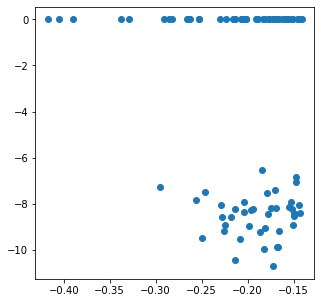




Run: 3
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0322593	0.0249738	-0.142973	-0.000265173
1  	250   	-0.0469729	0.031026 	-0.14639 	-0.00171539 
2  	250   	-0.0638692	0.0360352	-0.211771	-0.00365407 
3  	250   	-0.0744023	0.0364169	-0.199715	-0.0161717  
4  	250   	-0.0853351	0.0404738	-0.236113	-0.01102    
5  	250   	-0.0908803	0.0434457	-0.248869	-0.0165045  
6  	250   	-0.102426 	0.0414057	-0.246117	-0.0145826  
7  	250   	-0.10863  	0.0434441	-0.287686	-0.0187842  
8  	250   	-0.111995 	0.0367107	-0.205993	-0.0329628  
9  	250   	-0.114213 	0.0434708	-0.269665	-0.0278082  

N pep:  246
Best peptide: -9.430
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 026
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 153
N pep under -5 kcal/mol: 154
Non binding pep        : 092


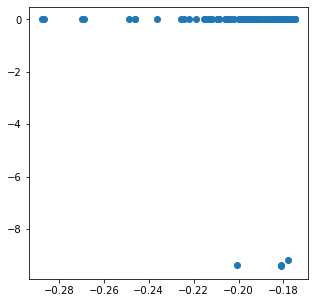




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0311715	0.0407756	-0.310047	-3.39959e-06
1  	250   	-0.0679935	0.0667323	-0.518419	-0.000329752
2  	250   	-0.086913 	0.0702788	-0.479475	-0.000130425
3  	250   	-0.124553 	0.0930227	-0.513662	-0.0006873  
4  	250   	-0.157068 	0.101612 	-0.573277	-0.00131491 
5  	250   	-0.166544 	0.102714 	-0.643824	-0.00783985 
6  	250   	-0.173407 	0.105419 	-0.580062	-0.0128797  
7  	250   	-0.183537 	0.102024 	-0.493217	-0.00970525 
8  	250   	-0.207284 	0.102929 	-0.487793	-0.00704256 
9  	250   	-0.19766  	0.113235 	-1.00759 	-0.00586611 

N pep:  342
Best peptide: -9.430
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 035
N pep under -7 kcal/mol: 136
N pep under -6 kcal/mol: 166
N pep under -5 kcal/mol: 167
Non binding pep        : 175


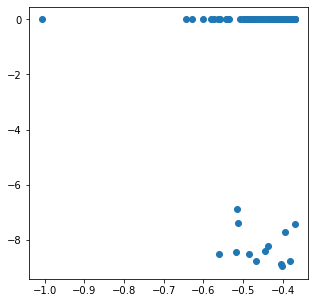




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0292864	0.0436302	-0.345383	-0.000308216
1  	250   	-0.0640984	0.0924618	-0.842182	-0.000371562
2  	250   	-0.0981176	0.109414 	-0.869162	-0.00103598 
3  	250   	-0.120375 	0.126028 	-0.816005	-0.00129101 
4  	250   	-0.14175  	0.137391 	-0.919986	-0.000721186
5  	250   	-0.17006  	0.144205 	-0.904851	-0.00263338 
6  	250   	-0.19646  	0.162628 	-0.935078	-0.00462205 
7  	250   	-0.208138 	0.173123 	-0.98956 	-0.00931745 
8  	250   	-0.234232 	0.171999 	-0.830714	-0.00943546 
9  	250   	-0.244814 	0.171895 	-0.889401	-0.00714171 

N pep:  438
Best peptide: -11.959
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 063
N pep under -7 kcal/mol: 177
N pep under -6 kcal/mol: 212
N pep under -5 kcal/mol: 213
Non binding pep        : 225


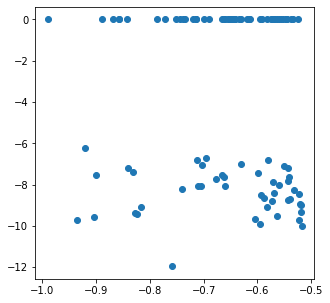




Run: 4
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std     	min      	max         
0  	250   	-0.0311486	0.026452	-0.190896	-7.42264e-05
1  	250   	-0.0531839	0.0331082	-0.188288	-0.00277288 
2  	250   	-0.0639112	0.032915 	-0.194477	-0.00843124 
3  	250   	-0.0758322	0.0395401	-0.227598	-0.0095962  
4  	250   	-0.0862983	0.0373017	-0.214279	-0.0178636  
5  	250   	-0.0920662	0.0384989	-0.208375	-0.0162902  
6  	250   	-0.106336 	0.0456933	-0.325745	-0.0221236  
7  	250   	-0.110735 	0.0402556	-0.245162	-0.0342401  
8  	250   	-0.108841 	0.0411889	-0.23715 	-0.0335262  
9  	250   	-0.119975 	0.0433009	-0.290533	-0.0165776  

N pep:  246
Best peptide: -9.817
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 152
Non binding pep        : 094


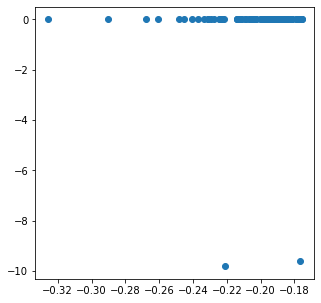




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0167632	0.0230155	-0.116012	-9.49434e-08
1  	250   	-0.0289154	0.0319701	-0.247731	-1.52587e-07
2  	250   	-0.0389298	0.0325711	-0.182154	-0.000246723
3  	250   	-0.0490822	0.0383517	-0.195121	-0.000167467
4  	250   	-0.0586482	0.0438017	-0.270875	-0.000217715
5  	250   	-0.0638496	0.0492017	-0.27007 	-9.1681e-05 
6  	250   	-0.0811605	0.0532489	-0.334854	-0.002474   
7  	250   	-0.0874396	0.0519589	-0.313804	-0.00688733 
8  	250   	-0.0870271	0.0517764	-0.307552	-0.00140543 
9  	250   	-0.098351 	0.0546724	-0.314965	-0.0169985  

N pep:  342
Best peptide: -9.817
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 030
N pep under -7 kcal/mol: 140
N pep under -6 kcal/mol: 171
N pep under -5 kcal/mol: 172
Non binding pep        : 170


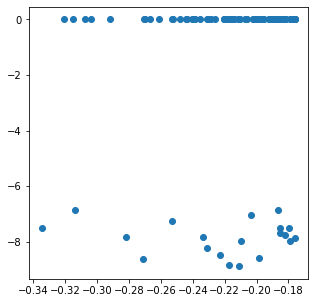




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0397035	0.0704365	-0.627072	-0.000174187
1  	250   	-0.0637569	0.0756388	-0.527445	-0.000340039
2  	250   	-0.10086  	0.115358 	-0.641656	-2.68269e-05
3  	250   	-0.103159 	0.118083 	-0.92922 	-0.00109372 
4  	250   	-0.108322 	0.114466 	-0.873034	-0.00150509 
5  	250   	-0.137705 	0.145513 	-0.936005	-0.000424609
6  	250   	-0.1524   	0.146958 	-0.95699 	-0.000756756
7  	250   	-0.173403 	0.154116 	-1.34184 	-0.00176281 
8  	250   	-0.197561 	0.171114 	-1.07802 	-0.00327024 
9  	250   	-0.203285 	0.184535 	-1.31325 	-0.0138567  

N pep:  438
Best peptide: -10.805
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 012
N pep under -8 kcal/mol: 049
N pep under -7 kcal/mol: 170
N pep under -6 kcal/mol: 202
N pep under -5 kcal/mol: 203
Non binding pep        : 235


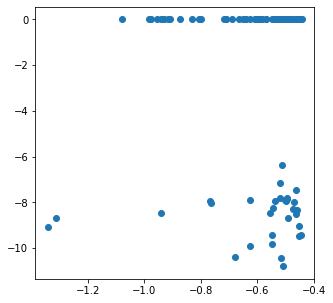




Run: 5
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max       
0  	250   	-0.0287392	0.0256577	-0.159175	-0.0001985
1  	250   	-0.0471202	0.0356581	-0.23535 	-0.00120388
2  	250   	-0.0596645	0.0382471	-0.26991 	-0.00579079
3  	250   	-0.0780589	0.0406155	-0.274141	-0.00931933
4  	250   	-0.0926004	0.0418452	-0.269697	-0.00809078
5  	250   	-0.102813 	0.0453691	-0.264053	-0.00965011
6  	250   	-0.109291 	0.0402561	-0.252507	-0.0232135 
7  	250   	-0.118834 	0.0438348	-0.257089	-0.0185695 
8  	250   	-0.126773 	0.0471937	-0.295898	-0.0330984 
9  	250   	-0.132896 	0.0449525	-0.276222	-0.0465718 

N pep:  246
Best peptide: -10.431
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 152
N pep under -5 kcal/mol: 153
Non binding pep        : 093


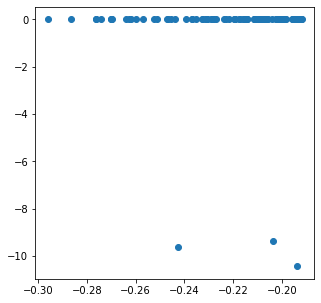




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min       	max         
0  	250   	-0.00876452	0.0131162	-0.0977232	-1.49956e-09
1  	250   	-0.0143146 	0.0139055	-0.0888304	-1.34732e-05
2  	250   	-0.0199243 	0.0174052	-0.118671 	-0.000241583
3  	250   	-0.0271336 	0.0236662	-0.126913 	-0.000319414
4  	250   	-0.0283361 	0.0228979	-0.116453 	-4.83485e-05
5  	250   	-0.0330082 	0.0265871	-0.157177 	-0.00102718 
6  	250   	-0.0394359 	0.0299261	-0.204391 	-0.000811013
7  	250   	-0.0398214 	0.0255957	-0.147647 	-0.00253145 
8  	250   	-0.0487306 	0.0357093	-0.230257 	-7.86157e-05
9  	250   	-0.0532936 	0.0339548	-0.211275 	-0.00411614 

N pep:  342
Best peptide: -10.431
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 136
N pep under -6 kcal/mol: 168
N pep under -5 kcal/mol: 169
Non binding pep        : 173


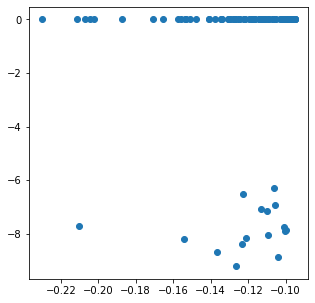




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0134004	0.0233277	-0.200154	-6.81594e-05
1  	250   	-0.0301091	0.0364196	-0.258995	-0.000188209
2  	250   	-0.0538787	0.0684786	-0.460325	-0.00054408 
3  	250   	-0.0687831	0.0722015	-0.446253	-0.000831379
4  	250   	-0.0910536	0.0827226	-0.410781	-0.00040373 
5  	250   	-0.131656 	0.109455 	-0.638524	-0.00445827 
6  	250   	-0.137611 	0.10442  	-0.671008	-0.00504303 
7  	250   	-0.145262 	0.0913843	-0.476961	-0.0051813  
8  	250   	-0.158164 	0.0991067	-0.507646	-0.014525   
9  	250   	-0.166503 	0.121939 	-0.834507	-0.00332277 

N pep:  438
Best peptide: -10.431
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 050
N pep under -7 kcal/mol: 165
N pep under -6 kcal/mol: 199
N pep under -5 kcal/mol: 200
Non binding pep        : 238


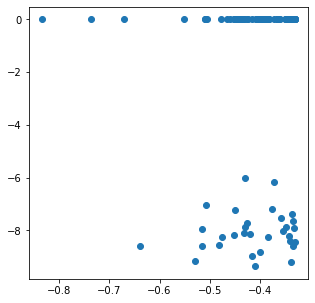




Run: 6
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min      	max         
0  	250   	-0.032506	0.0284302	-0.162174	-0.000146473
1  	250   	-0.0534957	0.0352387	-0.176882	-0.000521133
2  	250   	-0.0667188	0.0351849	-0.188589	-0.00964659 
3  	250   	-0.0781511	0.0385003	-0.220862	-0.00553313 
4  	250   	-0.091088 	0.0410893	-0.229182	-0.00985563 
5  	250   	-0.0983084	0.0415315	-0.258994	-0.0151063  
6  	250   	-0.115984 	0.0457452	-0.280687	-0.0279103  
7  	250   	-0.121908 	0.0434271	-0.257577	-0.0290691  
8  	250   	-0.127936 	0.0444689	-0.28964 	-0.0384842  
9  	250   	-0.130765 	0.0417116	-0.276445	-0.0320798  

N pep:  246
Best peptide: -10.915
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 029
N pep under -7 kcal/mol: 127
N pep under -6 kcal/mol: 156
N pep under -5 kcal/mol: 157
Non binding pep        : 089


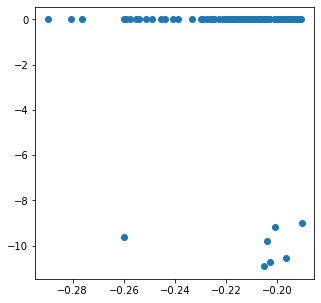




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min      	max         
0  	250   	-0.011732	0.0148172	-0.107889	-1.49049e-05
1  	250   	-0.0214579	0.0212419	-0.175414	-3.27656e-06
2  	250   	-0.0309984	0.0245655	-0.131937	-1.6083e-05 
3  	250   	-0.040019 	0.0255802	-0.144091	-5.75265e-05
4  	250   	-0.0427096	0.0280991	-0.179609	-0.00044307 
5  	250   	-0.0482069	0.0323997	-0.217509	-0.000571806
6  	250   	-0.0523713	0.0309688	-0.171921	-0.00339114 
7  	250   	-0.0514073	0.0339087	-0.231392	-0.00343855 
8  	250   	-0.0529245	0.0328988	-0.248711	-0.00446279 
9  	250   	-0.0582873	0.0342914	-0.182511	-0.00533419 

N pep:  342
Best peptide: -10.915
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 031
N pep under -7 kcal/mol: 131
N pep under -6 kcal/mol: 161
N pep under -5 kcal/mol: 162
Non binding pep        : 180


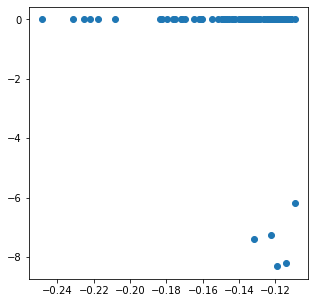




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min     	max        
0  	250   	-0.0134472	0.0233456	-0.17775	-1.5843e-05
1  	250   	-0.0221939	0.0333249	-0.226628	-3.38495e-05
2  	250   	-0.0292712	0.0414812	-0.266037	-0.000217338
3  	250   	-0.0377752	0.0467849	-0.336162	-0.000171736
4  	250   	-0.060655 	0.065969 	-0.393861	-0.000412094
5  	250   	-0.0595047	0.05958  	-0.381158	-0.00206445 
6  	250   	-0.0767538	0.0824953	-0.677483	-0.000931879
7  	250   	-0.0745151	0.0693224	-0.35148 	-0.00159929 
8  	250   	-0.0849232	0.0794851	-0.566001	-0.00354934 
9  	250   	-0.0947474	0.110653 	-1.36543 	-0.00306205 

N pep:  438
Best peptide: -10.915
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 038
N pep under -7 kcal/mol: 153
N pep under -6 kcal/mol: 188
N pep under -5 kcal/mol: 189
Non binding pep        : 249


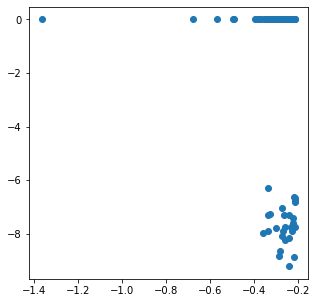




Run: 7
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max        
0  	250   	-0.0319367	0.0281794	-0.159739	-0.00052614
1  	250   	-0.0522793	0.0341525	-0.220272	-0.00196421
2  	250   	-0.0686456	0.0356644	-0.207737	-0.00749681
3  	250   	-0.0781643	0.0375732	-0.237997	-0.00805464
4  	250   	-0.0863636	0.0386302	-0.223204	-0.0130753 
5  	250   	-0.102789 	0.0436863	-0.261362	-0.0244593 
6  	250   	-0.107129 	0.0402881	-0.257603	-0.0243954 
7  	250   	-0.113506 	0.0451055	-0.265904	-0.0324764 
8  	250   	-0.116704 	0.0423035	-0.27474 	-0.0245583 
9  	250   	-0.126605 	0.0483719	-0.329707	-0.0269915 

N pep:  246
Best peptide: -10.655
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 026
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 153
N pep under -5 kcal/mol: 154
Non binding pep        : 092


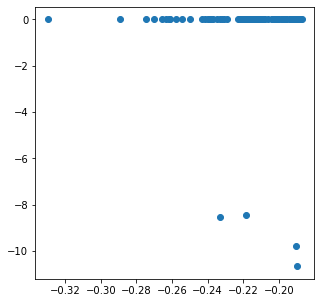




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00589152	0.00837869	-0.0523891	-5.44014e-07
1  	250   	-0.0119951 	0.0154665 	-0.125861 	-3.68607e-06
2  	250   	-0.0178572 	0.018175  	-0.115423 	-2.72843e-05
3  	250   	-0.0245133 	0.0224475 	-0.149829 	-0.000204163
4  	250   	-0.030344  	0.0233669 	-0.166852 	-0.000273091
5  	250   	-0.0352799 	0.025906  	-0.122742 	-0.00052136 
6  	250   	-0.0392377 	0.0305409 	-0.185288 	-0.00213292 
7  	250   	-0.0423308 	0.0278449 	-0.152959 	-0.00141018 
8  	250   	-0.0432522 	0.0303219 	-0.251235 	-0.00139941 
9  	250   	-0.0473126 	0.030498  	-0.185803 	-0.00507446 

N pep:  342
Best peptide: -10.655
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 132
N pep under -6 kcal/mol: 164
N pep under -5 kcal/mol: 166
Non binding pep        : 176


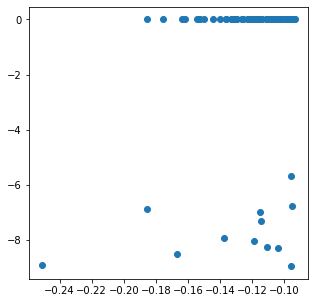




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0156625	0.0314077	-0.272384	-1.08838e-05
1  	250   	-0.0277171	0.0373929	-0.205881	-0.000170472
2  	250   	-0.0357868	0.0406551	-0.243773	-2.3542e-05 
3  	250   	-0.0410592	0.0494333	-0.37855 	-0.000216177
4  	250   	-0.0480509	0.0521723	-0.318794	-0.000547191
5  	250   	-0.0624252	0.068442 	-0.474332	-0.000533991
6  	250   	-0.0638926	0.065453 	-0.501285	-0.000214427
7  	250   	-0.0666034	0.0640572	-0.462883	-0.00138976 
8  	250   	-0.078705 	0.073025 	-0.486216	-7.52532e-05
9  	250   	-0.0759267	0.0760036	-0.533238	-0.000713077

N pep:  438
Best peptide: -10.655
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 045
N pep under -7 kcal/mol: 150
N pep under -6 kcal/mol: 184
N pep under -5 kcal/mol: 186
Non binding pep        : 252


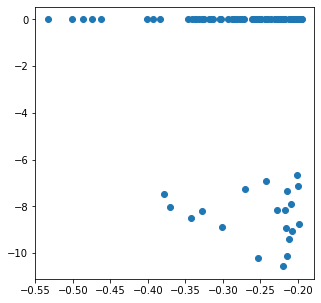




Run: 8
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max       
0  	250   	-0.0305021	0.0251327	-0.132526	-0.0011545
1  	250   	-0.0462114	0.0311502	-0.168979	-0.00168161
2  	250   	-0.0654359	0.0375028	-0.253776	-0.00481592
3  	250   	-0.0738552	0.0363455	-0.195233	-0.00744208
4  	250   	-0.0861277	0.040158 	-0.254588	-0.0182637 
5  	250   	-0.0952073	0.0434668	-0.218503	-0.0180372 
6  	250   	-0.0984771	0.0376295	-0.230587	-0.0264856 
7  	250   	-0.111652 	0.0448222	-0.348889	-0.0218515 
8  	250   	-0.118345 	0.0417161	-0.226782	-0.0323538 
9  	250   	-0.12337  	0.0412436	-0.268425	-0.037272  

N pep:  246
Best peptide: -10.365
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 152
N pep under -5 kcal/mol: 153
Non binding pep        : 093


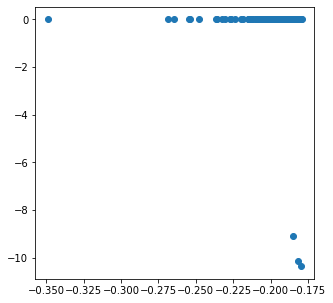




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min       	max         
0  	250   	-0.00918942	0.0130295	-0.0708102	-5.75378e-08
1  	250   	-0.0206614 	0.0247522	-0.188214 	-5.781e-05  
2  	250   	-0.030447  	0.0293502	-0.199675 	-6.00865e-05
3  	250   	-0.0377762 	0.0312164	-0.192111 	-0.000205988
4  	250   	-0.0425209 	0.0300775	-0.161548 	-0.00120861 
5  	250   	-0.0520138 	0.0331434	-0.206595 	-0.00247998 
6  	250   	-0.0551331 	0.0361168	-0.203764 	-0.00365031 
7  	250   	-0.0617924 	0.0375806	-0.259675 	-0.00254676 
8  	250   	-0.0653075 	0.0389257	-0.268363 	-0.00337872 
9  	250   	-0.0669062 	0.0400615	-0.299853 	-0.00508481 

N pep:  342
Best peptide: -10.365
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 028
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 168
N pep under -5 kcal/mol: 169
Non binding pep        : 173


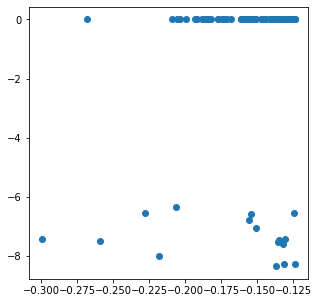




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0189287	0.0319492	-0.284252	-1.00318e-05
1  	250   	-0.0350245	0.0467709	-0.42672 	-7.06084e-05
2  	250   	-0.0471994	0.0455254	-0.447542	-0.00171703 
3  	250   	-0.0659132	0.0649409	-0.385899	-0.00101929 
4  	250   	-0.0709687	0.0664293	-0.477139	-0.000943322
5  	250   	-0.0813788	0.0711649	-0.561528	-0.0040976  
6  	250   	-0.115654 	0.0994667	-0.510381	-0.00813296 
7  	250   	-0.115131 	0.0897073	-0.554802	-0.00302997 
8  	250   	-0.126403 	0.0912866	-0.557783	-0.00471829 
9  	250   	-0.143591 	0.103685 	-0.562597	-0.00398369 

N pep:  438
Best peptide: -11.152
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 006
N pep under -8 kcal/mol: 049
N pep under -7 kcal/mol: 166
N pep under -6 kcal/mol: 202
N pep under -5 kcal/mol: 203
Non binding pep        : 235


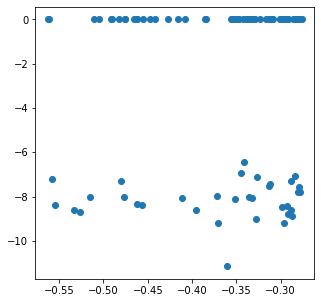




Run: 9
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std     	min      	max         
0  	250   	-0.0278648	0.022103	-0.119134	-0.000195762
1  	250   	-0.0466257	0.0311378	-0.196239	-0.00214175 
2  	250   	-0.0583656	0.0348149	-0.193477	-0.00395703 
3  	250   	-0.0687897	0.0394052	-0.250139	-0.00621911 
4  	250   	-0.0801826	0.0416358	-0.249747	-0.0116968  
5  	250   	-0.0940518	0.0412042	-0.23527 	-0.00593589 
6  	250   	-0.10064  	0.0412178	-0.235193	-0.0292526  
7  	250   	-0.107941 	0.0448396	-0.256279	-0.0303653  
8  	250   	-0.108321 	0.0431387	-0.271904	-0.0237079  
9  	250   	-0.111741 	0.0409356	-0.244182	-0.034438   

N pep:  246
Best peptide: -9.909
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 023
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 151
Non binding pep        : 095


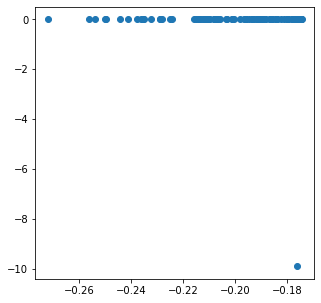




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0132711	0.0199793	-0.177844	-3.35155e-07
1  	250   	-0.0240905	0.0294164	-0.154532	-9.44395e-09
2  	250   	-0.0409439	0.0420502	-0.311028	-3.02524e-06
3  	250   	-0.0518109	0.0402081	-0.241665	-0.000357675
4  	250   	-0.0687063	0.0478002	-0.290967	-0.00238724 
5  	250   	-0.0736691	0.0471187	-0.259743	-0.00294589 
6  	250   	-0.0834844	0.0598091	-0.355041	-0.00746784 
7  	250   	-0.0848981	0.0584289	-0.399752	-0.00673013 
8  	250   	-0.0914666	0.0515689	-0.277696	-0.0131338  
9  	250   	-0.0943904	0.0560876	-0.422398	-0.0133731  

N pep:  342
Best peptide: -9.909
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 157
N pep under -5 kcal/mol: 158
Non binding pep        : 184


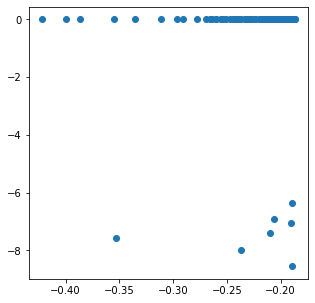




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0195181	0.0326643	-0.217824	-3.07461e-05
1  	250   	-0.0420446	0.0573123	-0.320305	-5.56271e-05
2  	250   	-0.0601827	0.0763053	-0.480535	-0.000154555
3  	250   	-0.0799071	0.091081 	-0.488667	-0.000476516
4  	250   	-0.0995216	0.102532 	-0.486667	-0.000863705
5  	250   	-0.110504 	0.112069 	-0.74656 	-9.09778e-06
6  	250   	-0.102131 	0.091732 	-0.662016	-0.000173766
7  	250   	-0.120117 	0.0968125	-0.584064	-0.000439921
8  	250   	-0.155087 	0.143785 	-0.911851	-0.000625611
9  	250   	-0.144789 	0.119475 	-0.686962	-0.00244808 

N pep:  438
Best peptide: -10.946
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 052
N pep under -7 kcal/mol: 167
N pep under -6 kcal/mol: 201
N pep under -5 kcal/mol: 202
Non binding pep        : 236


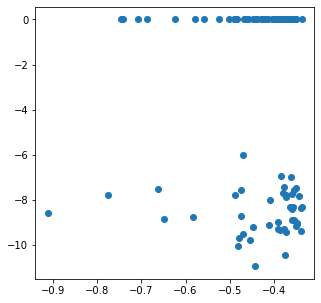




Run: 10
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max        
0  	250   	-0.0286697	0.0234344	-0.139404	-0.00153908
1  	250   	-0.0481164	0.0310987	-0.169313	-0.00400248
2  	250   	-0.0591106	0.0374266	-0.268383	-0.00589359
3  	250   	-0.0751971	0.0378946	-0.190097	-0.00995426
4  	250   	-0.0825398	0.0375397	-0.199129	-0.00650911
5  	250   	-0.0986237	0.0444013	-0.268576	-0.0259735 
6  	250   	-0.101053 	0.0451366	-0.251551	-0.0160124 
7  	250   	-0.114493 	0.0507187	-0.29846 	-0.0156775 
8  	250   	-0.121608 	0.049117 	-0.247777	-0.0279049 
9  	250   	-0.129217 	0.0431594	-0.258864	-0.0233604 

N pep:  246
Best peptide: -10.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 152
Non binding pep        : 094


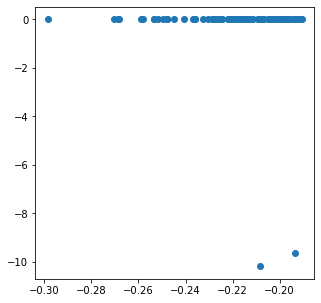




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max         
0  	250   	-0.0112746	0.0149675	-0.0975848	-2.86448e-07
1  	250   	-0.0214837	0.0244691	-0.150191 	-4.44942e-06
2  	250   	-0.0322398	0.0311263	-0.260176 	-0.000189727
3  	250   	-0.0416656	0.0313498	-0.129728 	-0.000514207
4  	250   	-0.0539967	0.0405526	-0.190259 	-0.000255477
5  	250   	-0.0679089	0.0467426	-0.303576 	-0.000933775
6  	250   	-0.0737206	0.0490279	-0.235817 	-0.00177822 
7  	250   	-0.0879974	0.049145 	-0.301164 	-0.0127638  
8  	250   	-0.0891315	0.0507221	-0.271851 	-0.0041481  
9  	250   	-0.108472 	0.0580035	-0.350675 	-0.0079775  

N pep:  342
Best peptide: -10.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 155
N pep under -5 kcal/mol: 156
Non binding pep        : 186


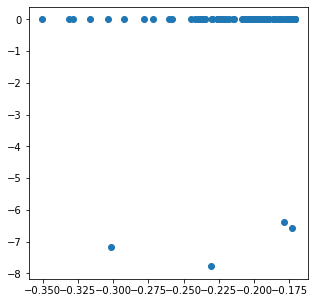




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std     	min      	max        
0  	250   	-0.0090896	0.015911	-0.121699	-2.2299e-05
1  	250   	-0.0198845	0.0318111	-0.327506	-1.06835e-05
2  	250   	-0.0282667	0.0413219	-0.31842 	-8.85515e-06
3  	250   	-0.0345438	0.0421983	-0.30245 	-8.70681e-05
4  	250   	-0.0394026	0.0453678	-0.250395	-0.000102548
5  	250   	-0.0526274	0.0528217	-0.34003 	-0.000309271
6  	250   	-0.060974 	0.0596553	-0.316338	-6.14083e-05
7  	250   	-0.0666532	0.0657442	-0.39514 	-3.86279e-05
8  	250   	-0.0691415	0.0563331	-0.304005	-2.19331e-05
9  	250   	-0.071558 	0.0622545	-0.3963  	-0.000311157

N pep:  438
Best peptide: -10.325
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 010
N pep under -8 kcal/mol: 047
N pep under -7 kcal/mol: 158
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 191
Non binding pep        : 247


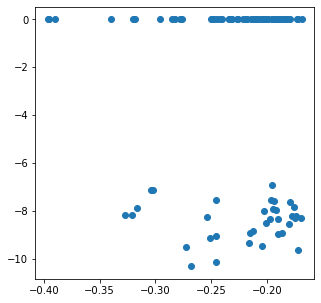

In [41]:
pbil_candidate_fps = []
pbil_candidate_y = []

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    pbil_candidate_fps.append(X_fps_exp.detach().numpy())
    pbil_candidate_y.append(y_exp.detach().numpy())


pbil_candidate_fps = np.array(pbil_candidate_fps)
pbil_candidate_y = np.array(pbil_candidate_y)

### Random candidate peptides sampling

In [42]:
def find_next_candidates_by_random(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96
    AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    
    sequences = np.array([''.join(s) for s in np.random.choice(AA1, (NGEN * NIND, NLEN))])
    
    sequence_acqs = scorer.evaluate(sequences)
    
    if greater_is_better:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))[::-1]
    else:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))
            
    candidates = sequences[sorted_peptide_indices[:NCAN]]
    candidate_acqs = sequence_acqs[sorted_peptide_indices[:NCAN]]
                        
    return candidates, candidate_acqs

Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.285
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 152
Non binding pep        : 094


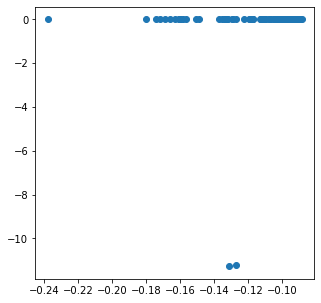




Generation: 2

N pep:  342
Best peptide: -11.285
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 006
N pep under -8 kcal/mol: 033
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 164
Non binding pep        : 178


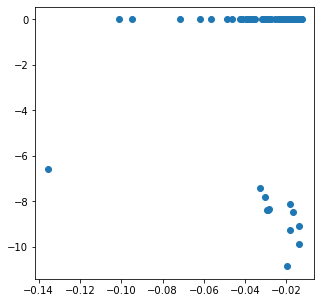




Generation: 3

N pep:  438
Best peptide: -11.285
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 039
N pep under -7 kcal/mol: 142
N pep under -6 kcal/mol: 174
N pep under -5 kcal/mol: 175
Non binding pep        : 263


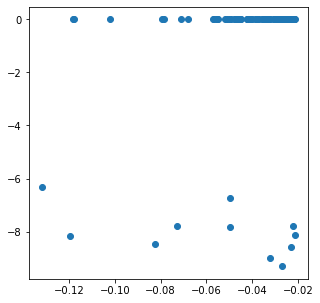




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.347
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 023
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 151
Non binding pep        : 095


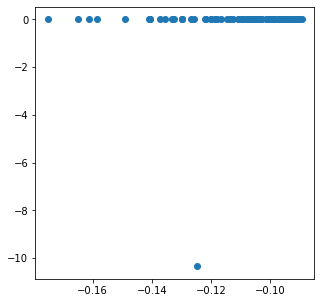




Generation: 2

N pep:  342
Best peptide: -10.347
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 028
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 155
N pep under -5 kcal/mol: 156
Non binding pep        : 186


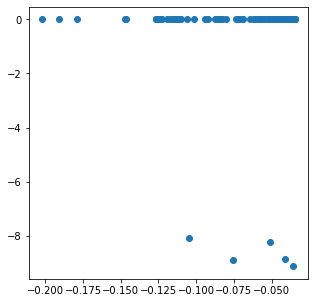




Generation: 3

N pep:  438
Best peptide: -10.641
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 034
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 164
Non binding pep        : 274


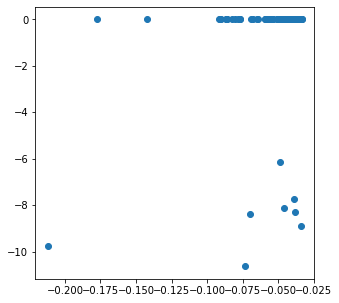




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.700
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 152
N pep under -5 kcal/mol: 153
Non binding pep        : 093


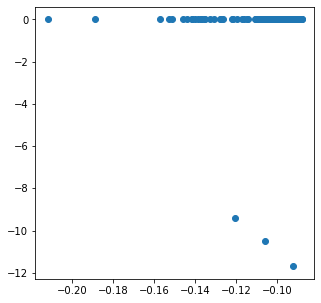




Generation: 2

N pep:  342
Best peptide: -11.700
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 029
N pep under -7 kcal/mol: 130
N pep under -6 kcal/mol: 160
N pep under -5 kcal/mol: 161
Non binding pep        : 181


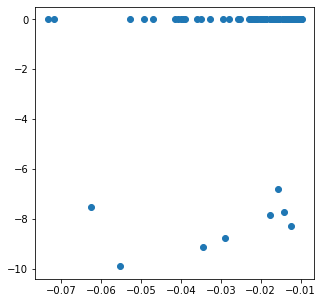




Generation: 3

N pep:  438
Best peptide: -11.700
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 039
N pep under -7 kcal/mol: 145
N pep under -6 kcal/mol: 176
N pep under -5 kcal/mol: 177
Non binding pep        : 261


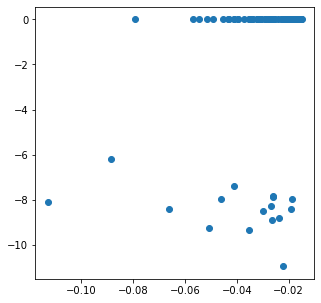




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.702
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 152
N pep under -5 kcal/mol: 153
Non binding pep        : 093


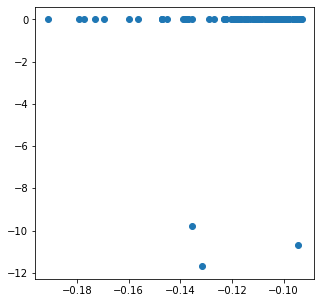




Generation: 2

N pep:  342
Best peptide: -11.702
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 029
N pep under -7 kcal/mol: 129
N pep under -6 kcal/mol: 159
N pep under -5 kcal/mol: 160
Non binding pep        : 182


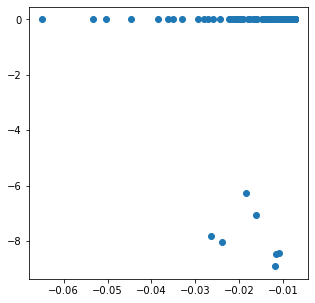




Generation: 3

N pep:  438
Best peptide: -11.702
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 036
N pep under -7 kcal/mol: 139
N pep under -6 kcal/mol: 171
N pep under -5 kcal/mol: 172
Non binding pep        : 266


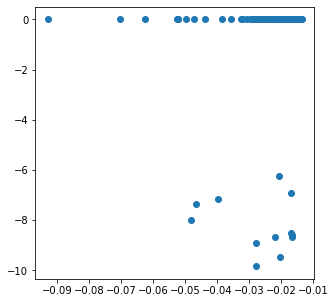




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.907
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 152
Non binding pep        : 094


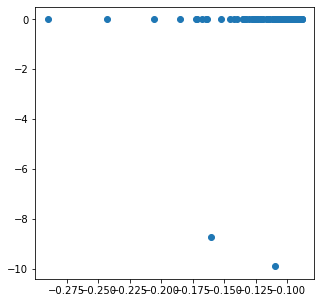




Generation: 2

N pep:  342
Best peptide: -9.907
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 027
N pep under -7 kcal/mol: 129
N pep under -6 kcal/mol: 160
N pep under -5 kcal/mol: 161
Non binding pep        : 181


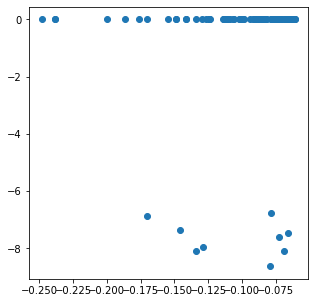




Generation: 3

N pep:  438
Best peptide: -9.907
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 034
N pep under -7 kcal/mol: 145
N pep under -6 kcal/mol: 177
N pep under -5 kcal/mol: 178
Non binding pep        : 260


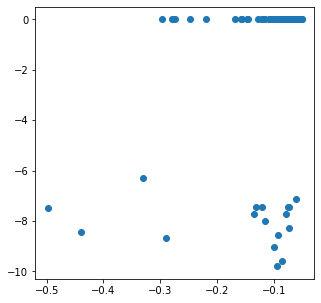




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.026
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 026
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 153
N pep under -5 kcal/mol: 154
Non binding pep        : 092


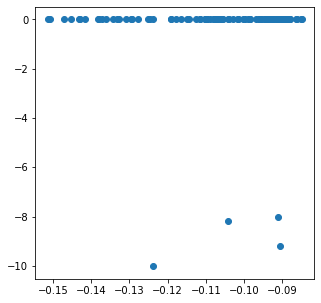




Generation: 2

N pep:  342
Best peptide: -10.026
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 030
N pep under -7 kcal/mol: 129
N pep under -6 kcal/mol: 159
N pep under -5 kcal/mol: 160
Non binding pep        : 182


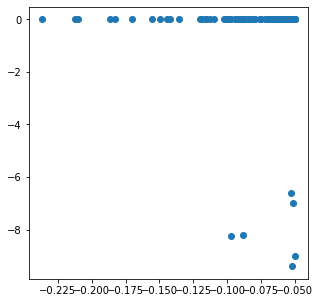




Generation: 3

N pep:  438
Best peptide: -10.026
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 033
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 164
Non binding pep        : 274


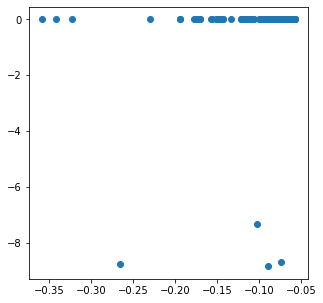




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.489
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 023
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 151
Non binding pep        : 095


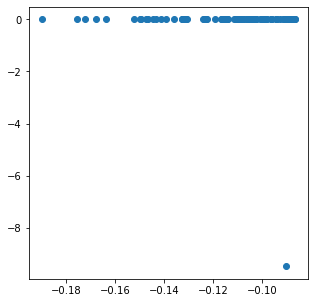




Generation: 2

N pep:  342
Best peptide: -9.654
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 129
N pep under -6 kcal/mol: 161
N pep under -5 kcal/mol: 162
Non binding pep        : 180


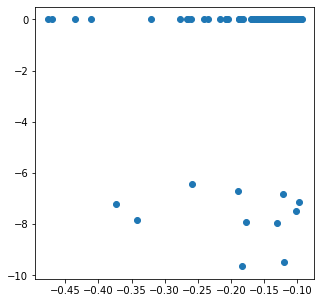




Generation: 3

N pep:  438
Best peptide: -9.654
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 139
N pep under -6 kcal/mol: 173
N pep under -5 kcal/mol: 174
Non binding pep        : 264


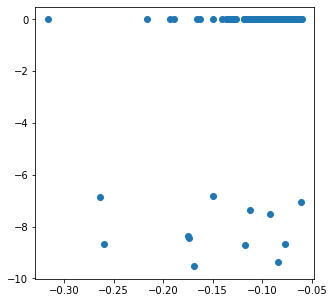




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.761
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 152
Non binding pep        : 094


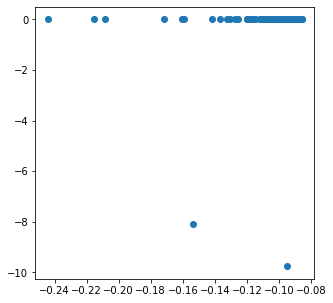




Generation: 2

N pep:  342
Best peptide: -9.761
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 028
N pep under -7 kcal/mol: 128
N pep under -6 kcal/mol: 158
N pep under -5 kcal/mol: 159
Non binding pep        : 183


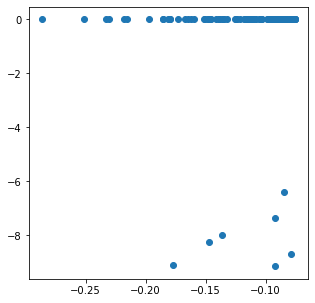




Generation: 3

N pep:  438
Best peptide: -9.761
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 039
N pep under -7 kcal/mol: 150
N pep under -6 kcal/mol: 181
N pep under -5 kcal/mol: 182
Non binding pep        : 256


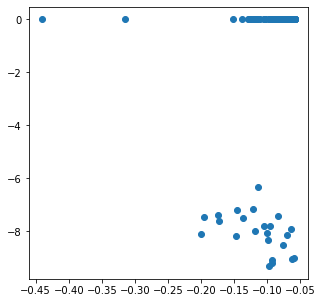




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.734
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 023
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 151
Non binding pep        : 095


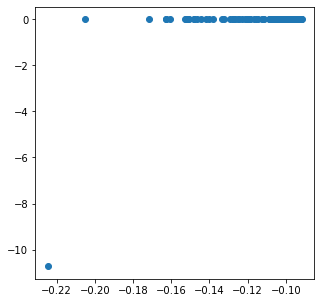




Generation: 2

N pep:  342
Best peptide: -10.734
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 135
N pep under -6 kcal/mol: 165
N pep under -5 kcal/mol: 166
Non binding pep        : 176


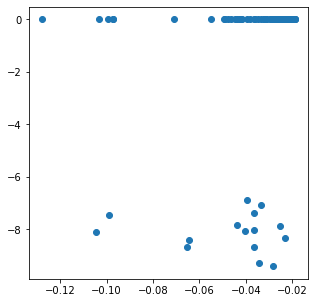




Generation: 3

N pep:  438
Best peptide: -10.734
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 006
N pep under -8 kcal/mol: 042
N pep under -7 kcal/mol: 147
N pep under -6 kcal/mol: 177
N pep under -5 kcal/mol: 178
Non binding pep        : 260


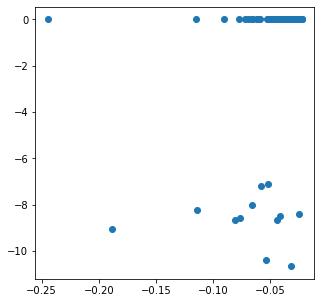




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.495
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 023
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 151
Non binding pep        : 095


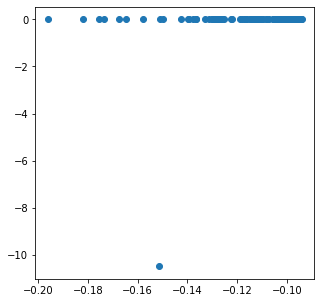




Generation: 2

N pep:  342
Best peptide: -10.495
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 027
N pep under -7 kcal/mol: 127
N pep under -6 kcal/mol: 156
N pep under -5 kcal/mol: 157
Non binding pep        : 185


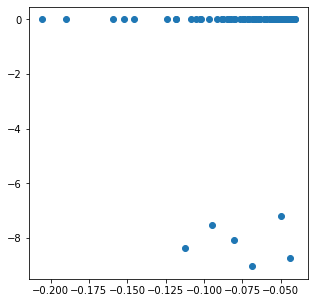




Generation: 3

N pep:  438
Best peptide: -10.495
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 033
N pep under -7 kcal/mol: 140
N pep under -6 kcal/mol: 170
N pep under -5 kcal/mol: 171
Non binding pep        : 267


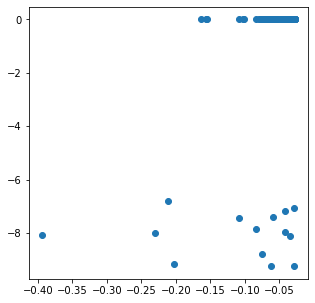

In [43]:
random_candidate_fps = []
random_candidate_y = []

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates_by_random(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    random_candidate_fps.append(X_fps_exp.detach().numpy())
    random_candidate_y.append(y_exp.detach().numpy())


random_candidate_fps = np.array(random_candidate_fps)
random_candidate_y = np.array(random_candidate_y)

### Candidate peptides sampling with custom GA

In [44]:
def parse_helm(helm_string):
    dtype = [('SourcePolymerID', 'U20'), ('TargetPolymerID', 'U20'),
             ('SourceMonomerPosition', 'i4'), ('SourceAttachment', 'U2'),
             ('TargetMonomerPosition', 'i4'), ('TargetAttachment', 'U2')]
    
    polymers, connections, hydrogen_bonds, attributes, _ = helm_string.split('$')
    
    # Process sequences
    data = {}
    for polymer in polymers.split('|'):
        pid = polymer.split('{')[0]
        sequence = polymer[len(pid) + 1:-1].replace('.', '')
        data[pid] = sequence
        
    polymers = data
        
    # Process connections
    data = []
    if connections:
        for connection in connections.split('|'):
            source_id, target_id, con = connection.split(',')
            source_position, source_attachment = con.split('-')[0].split(':')
            target_position, target_attachment = con.split('-')[1].split(':')
            data.append((source_id, target_id,
                         source_position, source_attachment,
                         target_position, target_attachment))
        
    connections = np.array(data, dtype=dtype)
    
    return polymers, connections, hydrogen_bonds, attributes


def build_helm_string(polymers, connections):
    sequences_str = '|'.join(['%s{%s}' % (p, '.'.join(s)) for p, s in polymers.items()])
    if len(connections) > 0:
        connections_str = '|'.join(['%s,%s,%d:%s-%d:%s' % (c[0], c[1], c[2], c[3], c[4], c[5]) for c in connections])
    else:
        connections_str = ''
    helm_string = '%s$%s$$$V2.0' % (sequences_str, connections_str)
    
    return helm_string


class HELMGeneticOperators:
    
    def __init__(self, monomer_library, probability_matrix=None, seed=None):
        self._monomer_library = monomer_library
        self._monomer_symbols = [m['symbol'] for m in self._monomer_library]
        self._probability_matrix = probability_matrix
        
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

    def mutate(self, helm_string, n=10, minimum_mutations=1, maximum_mutations=None, keep_connections=True):
        mutant_helm_strings = []
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        # Generate mutants...
        for i in range(n):
            mutant_polymers = {}
            n_mutations = 0
            
            for pid, sequence in polymers.items():
                mutated_sequence = list(sequence)
                
                # Residues involved in a connection within and between peptides won't be mutated
                if keep_connections and pid in polymers.keys():
                    connection_resids = list(connections[connections['SourcePolymerID'] == pid]['SourceMonomerPosition'])
                    connection_resids += list(connections[connections['TargetPolymerID'] == pid]['TargetMonomerPosition'])
                    # Because positions are 1-based in HELM
                    connection_resids = np.array(connection_resids) - 1
                    
                    possible_positions = list(set(range(len(sequence))).difference(connection_resids))
                else:
                    possible_positions = list(range(len(sequence)))
                
                # Choose a random number of mutations between min and max
                if minimum_mutations == maximum_mutations:
                    number_mutations = maximum_mutations
                elif maximum_mutations is None:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=len(sequence))
                else:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=maximum_mutations)
                
                # Choose positions to mutate
                mutation_positions = self._rng.choice(possible_positions, size=number_mutations, replace=False)
                
                # Do mutations
                for mutation_position in mutation_positions:                    
                    monomer_symbol = mutated_sequence[mutation_position]
                    
                    # Force mutation!
                    while monomer_symbol == mutated_sequence[mutation_position]:
                        # Instead of mutating to random monomer, the selection will be
                        # based on the probability matrix
                        if self._probability_matrix is not None:
                            index_symbol = self._monomer_symbols.index(monomer_symbol)
                            p = probability_matrix[index_symbol]
                        else:
                            p = None
                        
                        chosen_monomer = self._rng.choice(self._monomer_symbols, p=p)
                        mutated_sequence[mutation_position] = chosen_monomer
                
                mutant_polymers[pid] = (mutated_sequence, mutation_positions)
                n_mutations += len(mutation_positions)
            
            if n_mutations > 0:
                if not keep_connections:
                    connections_to_keep = []

                    # Check if we have to remove connections due to the mutations
                    for i, connection in enumerate(connections):
                        # The connection positions must not be in the mutation lists
                        # mutant_polymers[connection['XXXXXPolymerID']][1] + 1 because positions are 1-based in HELM
                        if connection['SourceMonomerPosition'] not in mutant_polymers[connection['SourcePolymerID']][1] + 1 and \
                           connection['TargetMonomerPosition'] not in mutant_polymers[connection['TargetPolymerID']][1] + 1:
                            connections_to_keep.append(i)
                else:
                    connections_to_keep = list(range(connections.shape[0]))

                # Reconstruct the HELM string
                mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, connections[connections_to_keep])
                mutant_helm_strings.append(mutant_helm_string)
            else:
                mutant_helm_strings.append(helm_string)
        
        return mutant_helm_strings
            

In [45]:
def find_next_candidates_with_custom_GA(scorer, best_peptide, monomer_lib, probability_matrix, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96
    
    polymers = {'PEPTIDE1': best_peptide}
    helm_string = build_helm_string(polymers, [])
    m = HELMGeneticOperators(monomer_lib, probability_matrix=probability_matrix)
    
    all_sequences = []
    all_sequence_acqs = []
    
    for i in range(NGEN):
        sequences = m.mutate(helm_string, n=NIND, minimum_mutations=1, maximum_mutations=2)
        sequence_acqs = scorer.evaluate(sequences)
        
        # Take the best peptide
        if greater_is_better:
            seq_idx = np.argmax(np.ravel(sequence_acqs))
        else:
            seq_idx = np.argmin(np.ravel(sequence_acqs))
            
        helm_string = sequences[seq_idx]
        
        all_sequences.extend(sequences)
        all_sequence_acqs.extend(np.ravel(sequence_acqs))
        
    # Remove duplicates
    all_sequences, indices = np.unique(all_sequences, return_index=True)
    all_sequence_acqs = np.array(all_sequence_acqs)[indices]
        
    if greater_is_better:
        sorted_peptide_indices = np.argsort(all_sequence_acqs)[::-1]
    else:
        sorted_peptide_indices = np.argsort(all_sequence_acqs)
    
    # Select candidates
    candidates = all_sequences[sorted_peptide_indices[:NCAN]]
    candidate_acqs = all_sequence_acqs[sorted_peptide_indices[:NCAN]]
    
    # Convert HELM to FASTA
    candidates = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in candidates]
                        
    return candidates, candidate_acqs

In [46]:
with open('HELMCoreLibrary.json') as f:
    monomer_lib = json.load(f)

monomer_peptide_lib = [x for x in monomer_lib if x['polymerType'] == 'PEPTIDE']
AA1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
monomer_aa1_lib = [x for x in monomer_peptide_lib if x['symbol'] in AA1]

smiles = [monomer['smiles'] for monomer in monomer_aa1_lib]
fps = map4_fingerprint(smiles,input_type='smiles', radius=2)
t = TanimotoSimilarityKernel()
similarity_matrix = t.forward(fps, fps).numpy()

probability_matrix = []

for aa in similarity_matrix:
    tmp = aa.copy()
    tmp[tmp == 1.0] = 0
    probability_matrix.append(tmp / np.sum(tmp))
    
probability_matrix = np.array(probability_matrix)

Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 015
N pep under -8 kcal/mol: 046
N pep under -7 kcal/mol: 144
N pep under -6 kcal/mol: 173
N pep under -5 kcal/mol: 174
Non binding pep        : 072


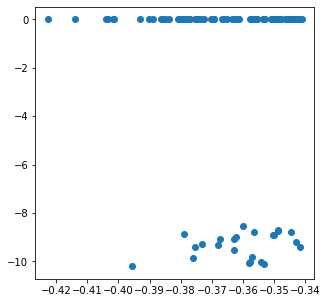




Generation: 2

N pep:  342
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 015
N pep under -8 kcal/mol: 046
N pep under -7 kcal/mol: 144
N pep under -6 kcal/mol: 173
N pep under -5 kcal/mol: 174
Non binding pep        : 168


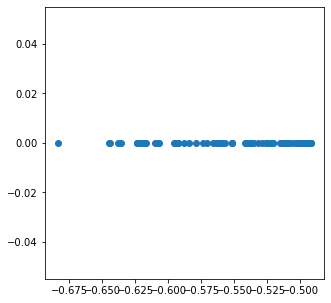




Generation: 3

N pep:  438
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 015
N pep under -8 kcal/mol: 046
N pep under -7 kcal/mol: 144
N pep under -6 kcal/mol: 173
N pep under -5 kcal/mol: 174
Non binding pep        : 264


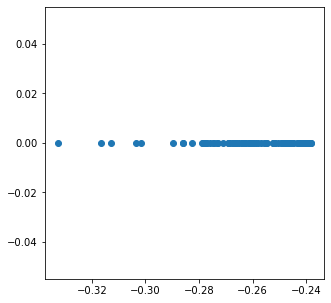




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.402
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 033
N pep under -8 kcal/mol: 079
N pep under -7 kcal/mol: 177
N pep under -6 kcal/mol: 206
N pep under -5 kcal/mol: 207
Non binding pep        : 039


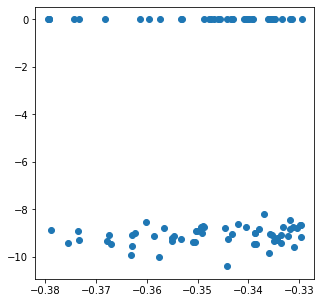




Generation: 2

N pep:  342
Best peptide: -10.928
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 038
N pep under -8 kcal/mol: 084
N pep under -7 kcal/mol: 182
N pep under -6 kcal/mol: 211
N pep under -5 kcal/mol: 212
Non binding pep        : 130


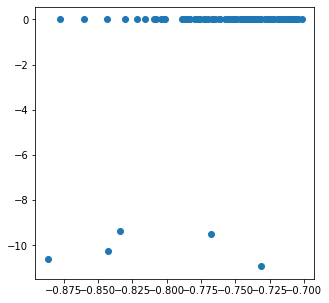




Generation: 3

N pep:  438
Best peptide: -10.928
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 007
N pep under -9 kcal/mol: 059
N pep under -8 kcal/mol: 153
N pep under -7 kcal/mol: 255
N pep under -6 kcal/mol: 284
N pep under -5 kcal/mol: 285
Non binding pep        : 153


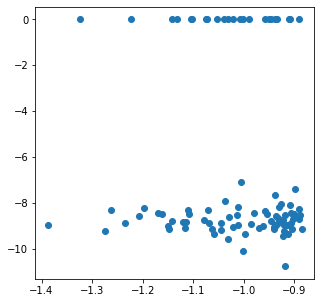




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.723
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 018
N pep under -8 kcal/mol: 051
N pep under -7 kcal/mol: 149
N pep under -6 kcal/mol: 178
N pep under -5 kcal/mol: 179
Non binding pep        : 067


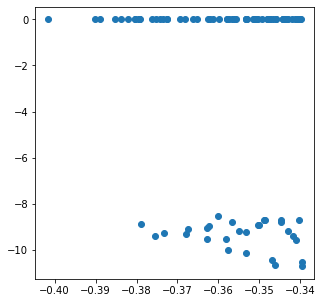




Generation: 2

N pep:  342
Best peptide: -10.723
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 018
N pep under -8 kcal/mol: 051
N pep under -7 kcal/mol: 149
N pep under -6 kcal/mol: 178
N pep under -5 kcal/mol: 179
Non binding pep        : 163


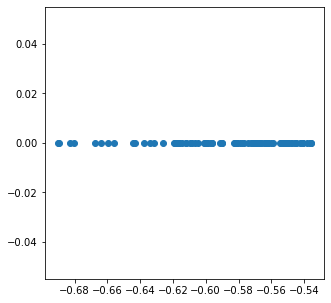




Generation: 3

N pep:  438
Best peptide: -10.723
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 013
N pep under -9 kcal/mol: 081
N pep under -8 kcal/mol: 118
N pep under -7 kcal/mol: 218
N pep under -6 kcal/mol: 247
N pep under -5 kcal/mol: 248
Non binding pep        : 190


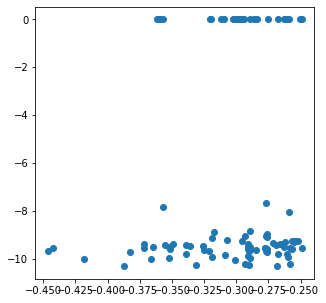




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 018
N pep under -8 kcal/mol: 051
N pep under -7 kcal/mol: 149
N pep under -6 kcal/mol: 178
N pep under -5 kcal/mol: 179
Non binding pep        : 067


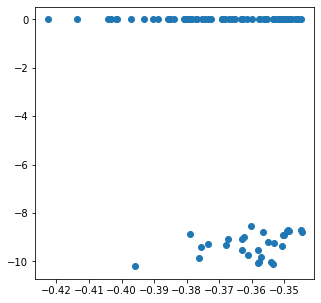




Generation: 2

N pep:  342
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 018
N pep under -8 kcal/mol: 051
N pep under -7 kcal/mol: 149
N pep under -6 kcal/mol: 178
N pep under -5 kcal/mol: 179
Non binding pep        : 163


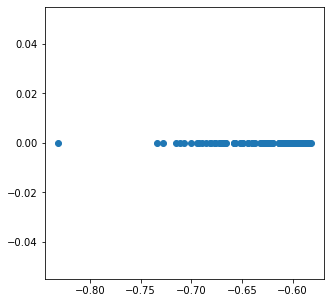




Generation: 3

N pep:  438
Best peptide: -10.361
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 023
N pep under -8 kcal/mol: 060
N pep under -7 kcal/mol: 159
N pep under -6 kcal/mol: 188
N pep under -5 kcal/mol: 189
Non binding pep        : 249


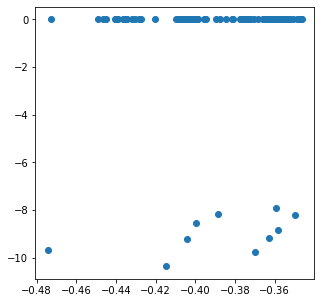




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.120
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 025
N pep under -8 kcal/mol: 078
N pep under -7 kcal/mol: 176
N pep under -6 kcal/mol: 205
N pep under -5 kcal/mol: 206
Non binding pep        : 040


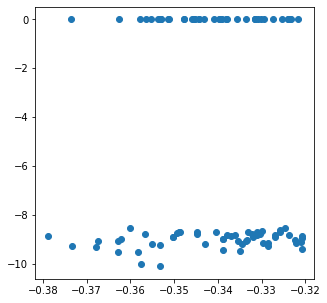




Generation: 2

N pep:  342
Best peptide: -10.120
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 028
N pep under -8 kcal/mol: 085
N pep under -7 kcal/mol: 185
N pep under -6 kcal/mol: 214
N pep under -5 kcal/mol: 215
Non binding pep        : 127


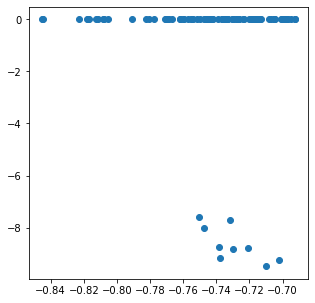




Generation: 3

N pep:  438
Best peptide: -10.120
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 034
N pep under -8 kcal/mol: 136
N pep under -7 kcal/mol: 265
N pep under -6 kcal/mol: 294
N pep under -5 kcal/mol: 295
Non binding pep        : 143


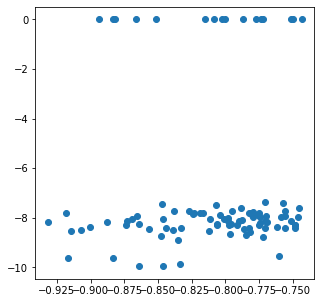




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.004
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 018
N pep under -8 kcal/mol: 056
N pep under -7 kcal/mol: 154
N pep under -6 kcal/mol: 183
N pep under -5 kcal/mol: 184
Non binding pep        : 062


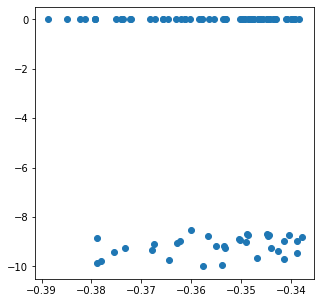




Generation: 2

N pep:  342
Best peptide: -10.004
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 018
N pep under -8 kcal/mol: 057
N pep under -7 kcal/mol: 155
N pep under -6 kcal/mol: 184
N pep under -5 kcal/mol: 185
Non binding pep        : 157


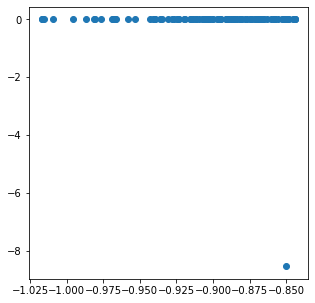




Generation: 3

N pep:  438
Best peptide: -10.004
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 019
N pep under -8 kcal/mol: 069
N pep under -7 kcal/mol: 169
N pep under -6 kcal/mol: 198
N pep under -5 kcal/mol: 199
Non binding pep        : 239


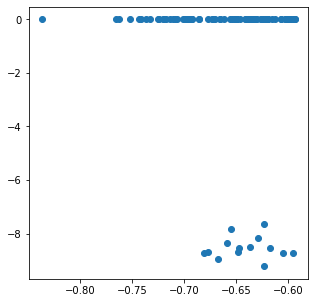




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.666
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 034
N pep under -8 kcal/mol: 073
N pep under -7 kcal/mol: 171
N pep under -6 kcal/mol: 200
N pep under -5 kcal/mol: 201
Non binding pep        : 045


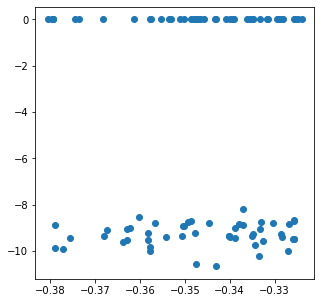




Generation: 2

N pep:  342
Best peptide: -10.666
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 008
N pep under -9 kcal/mol: 041
N pep under -8 kcal/mol: 081
N pep under -7 kcal/mol: 179
N pep under -6 kcal/mol: 208
N pep under -5 kcal/mol: 209
Non binding pep        : 133


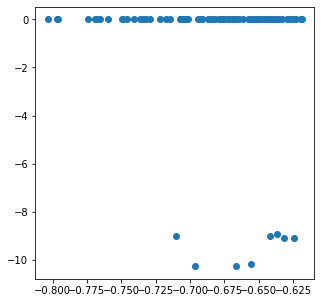




Generation: 3

N pep:  438
Best peptide: -10.719
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 014
N pep under -9 kcal/mol: 063
N pep under -8 kcal/mol: 147
N pep under -7 kcal/mol: 265
N pep under -6 kcal/mol: 294
N pep under -5 kcal/mol: 295
Non binding pep        : 143


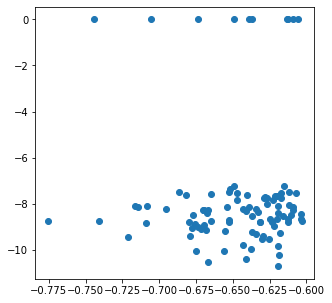




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.333
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 043
N pep under -7 kcal/mol: 141
N pep under -6 kcal/mol: 170
N pep under -5 kcal/mol: 171
Non binding pep        : 075


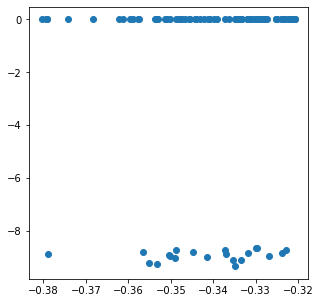




Generation: 2

N pep:  342
Best peptide: -9.333
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 043
N pep under -7 kcal/mol: 142
N pep under -6 kcal/mol: 171
N pep under -5 kcal/mol: 172
Non binding pep        : 170


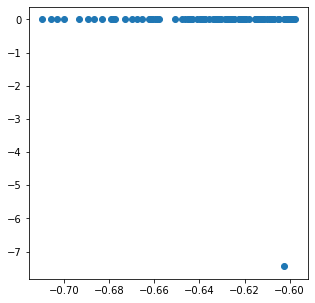




Generation: 3

N pep:  438
Best peptide: -9.697
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 056
N pep under -7 kcal/mol: 203
N pep under -6 kcal/mol: 241
N pep under -5 kcal/mol: 242
Non binding pep        : 196


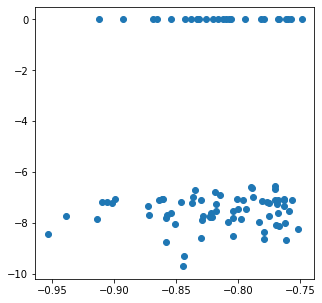




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.848
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 025
N pep under -8 kcal/mol: 060
N pep under -7 kcal/mol: 158
N pep under -6 kcal/mol: 187
N pep under -5 kcal/mol: 188
Non binding pep        : 058


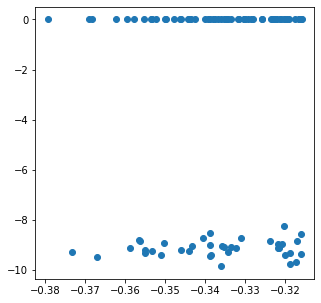




Generation: 2

N pep:  342
Best peptide: -9.848
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 025
N pep under -8 kcal/mol: 060
N pep under -7 kcal/mol: 158
N pep under -6 kcal/mol: 187
N pep under -5 kcal/mol: 188
Non binding pep        : 154


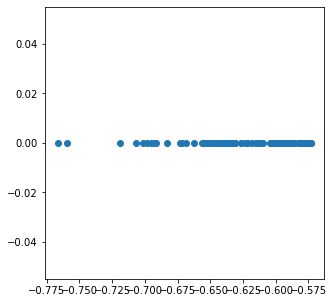




Generation: 3

N pep:  438
Best peptide: -9.848
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 025
N pep under -8 kcal/mol: 060
N pep under -7 kcal/mol: 158
N pep under -6 kcal/mol: 187
N pep under -5 kcal/mol: 188
Non binding pep        : 250


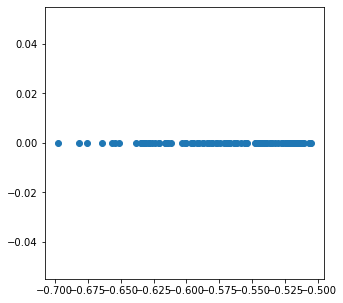




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 016
N pep under -8 kcal/mol: 048
N pep under -7 kcal/mol: 146
N pep under -6 kcal/mol: 175
N pep under -5 kcal/mol: 176
Non binding pep        : 070


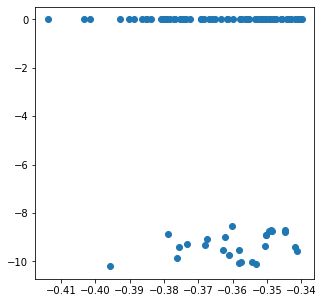




Generation: 2

N pep:  342
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 049
N pep under -7 kcal/mol: 147
N pep under -6 kcal/mol: 176
N pep under -5 kcal/mol: 177
Non binding pep        : 165


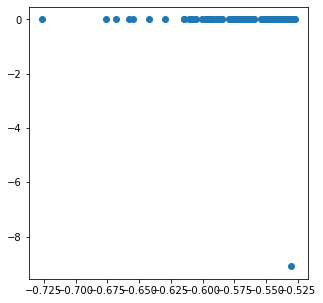




Generation: 3

N pep:  438
Best peptide: -10.208
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 055
N pep under -7 kcal/mol: 154
N pep under -6 kcal/mol: 183
N pep under -5 kcal/mol: 184
Non binding pep        : 254


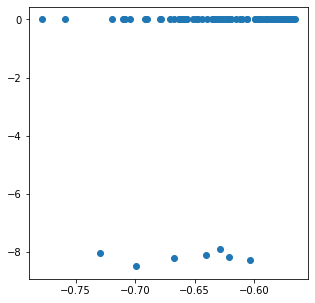

In [47]:
custom_candidate_fps = []
custom_candidate_y = []

for i in range(10):
    print('Run: %s' % (i + 1))

    # Get best random peptide
    best_peptide = random_peptides[np.argmin(random_peptide_scores)]
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm')
        candidate_sequences, candidates_acq = find_next_candidates_with_custom_GA(acq, best_peptide, monomer_aa1_lib, probability_matrix, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])
        
        # Get best peptide found so far
        best_peptide = candidate_sequences[np.argmin(y_candidates.numpy())]

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    custom_candidate_fps.append(X_fps_exp.detach().numpy())
    custom_candidate_y.append(y_exp.detach().numpy())


custom_candidate_fps = np.array(custom_candidate_fps)
custom_candidate_y = np.array(custom_candidate_y)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
axarr[0].hist(random_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[1].hist(pbil_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[2].hist(custom_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))

axarr[0].set_title('Random sampling (10 runs of 3 generations)', fontsize=20)
axarr[1].set_title('Sampling with PBIL (10 runs of 3 generations)', fontsize=20)
axarr[2].set_title('Custom GA sampling (10 runs of 3 generations)', fontsize=20)

axarr[0].set_ylabel('#Peptides tested', fontsize=20)
axarr[0].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[1].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[2].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)

plt.savefig('figure_baye_opt_comparison_random_vs_pbil_vs_custom_GA_sampling.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
axarr[0].hist(random_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[1].hist(pbil_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[2].hist(custom_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))

axarr[0].set_title('Random sampling (10 runs of 3 generations)', fontsize=20)
axarr[1].set_title('Sampling with PBIL (10 runs of 3 generations)', fontsize=20)
axarr[2].set_title('Custom GA sampling (10 runs of 3 generations)', fontsize=20)

axarr[0].set_ylabel('#Peptides tested', fontsize=20)
axarr[0].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[1].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[2].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)

plt.savefig('figure_baye_opt_comparison_random_vs_pbil_vs_custom_GA_sampling_using_same_starting_peptides.png', dpi=300, bbox_inches='tight')
plt.show()

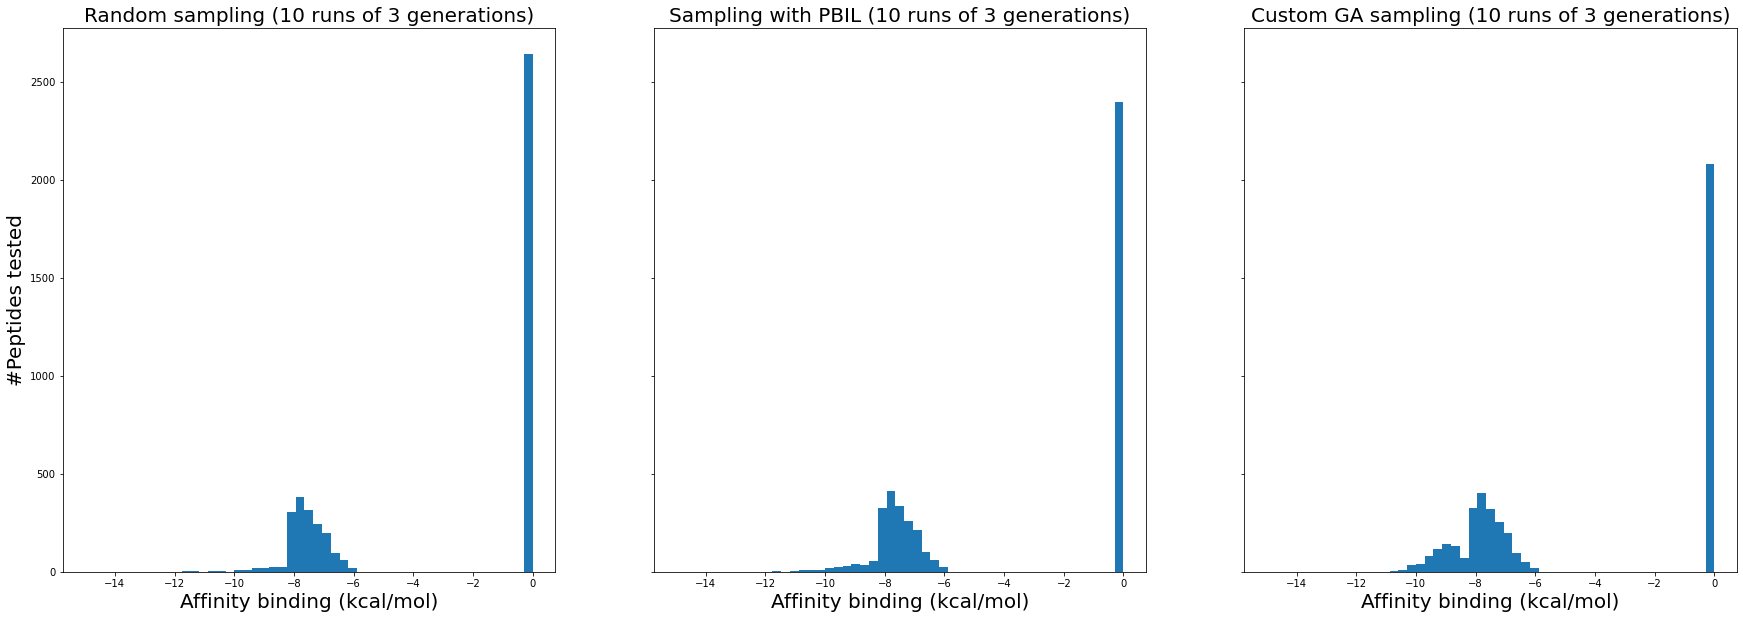

In [48]:
fig, axarr = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
axarr[0].hist(random_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[1].hist(pbil_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[2].hist(custom_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))

axarr[0].set_title('Random sampling (10 runs of 3 generations)', fontsize=20)
axarr[1].set_title('Sampling with PBIL (10 runs of 3 generations)', fontsize=20)
axarr[2].set_title('Custom GA sampling (10 runs of 3 generations)', fontsize=20)

axarr[0].set_ylabel('#Peptides tested', fontsize=20)
axarr[0].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[1].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[2].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)

plt.savefig('figure_baye_opt_comparison_random_vs_pbil_vs_custom_GA_sampling_using_same_starting_peptides_harder.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
candidate_sequences

['RAAYELLLA',
 'RAAYELFLA',
 'RAAYLLLLA',
 'AAAYELLLA',
 'RNAYELLLA',
 'RAAYETLLA',
 'RAAYELLLI',
 'RCAYELLLA',
 'AAAYYLLLA',
 'RAAYELLAA',
 'RAFYELLLA',
 'RAAYELTLA',
 'ATAYELLLA',
 'RAAYELALA',
 'RAAYFLLLA',
 'RAAFELLLA',
 'RAAYELLLT',
 'LAAYELLLA',
 'AAAMELLLA',
 'ALAMELALA',
 'ALAYELLLA',
 'AAFYELLLA',
 'ACAYELLLA',
 'AAAYELALA',
 'AAAYELLAA',
 'RAAYEALLA',
 'RAAYELLTA',
 'RAAAELLLA',
 'AAAMELALA',
 'RMAYELLLA',
 'AAAYLLLLA',
 'RAAYELLLY',
 'RAAYEELLA',
 'ACAMELALA',
 'RAAMELLLA',
 'AAAYELLLY',
 'AAAMELALT',
 'RVAYELLLA',
 'RAAYELYLA',
 'AAAYALLLA',
 'RANYELLLA',
 'ANAMELALA',
 'CAAYELLLA',
 'ALAMELLLA',
 'TAAYELLLA',
 'LAAMELALA',
 'RAAYCLLLA',
 'RAAYELELA',
 'AAAMELALY',
 'RAAYNLLLA',
 'RACYELLLA',
 'AAYMELALA',
 'AMAYELLLA',
 'AAAWELALA',
 'AAAMELMLA',
 'AAAYFLLLA',
 'AAAFELLLA',
 'AAAYEELLA',
 'RAAYELLYA',
 'LAAMELLLA',
 'AAYMELLLA',
 'RYAYELLLA',
 'RAAYELMLA',
 'AAAYELYLA',
 'ANAMELLLA',
 'AAAWELLLA',
 'ACAMELLLA',
 'MAAYELLLA',
 'AAMMELLLA',
 'AAAYELLTA',
 'AFAYELLLA',
 'RAAW